<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Загрузка-данных" data-toc-modified-id="Загрузка-данных-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Загрузка данных</a></span></li><li><span><a href="#Умножение-матриц" data-toc-modified-id="Умножение-матриц-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Умножение матриц</a></span><ul class="toc-item"><li><span><a href="#Обоснование" data-toc-modified-id="Обоснование-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Обоснование</a></span></li><li><span><a href="#Вывод" data-toc-modified-id="Вывод-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Вывод</a></span></li></ul></li><li><span><a href="#Алгоритм-преобразования" data-toc-modified-id="Алгоритм-преобразования-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Алгоритм преобразования</a></span></li><li><span><a href="#Проверка-алгоритма" data-toc-modified-id="Проверка-алгоритма-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Проверка алгоритма</a></span></li><li><span><a href="#Вывод" data-toc-modified-id="Вывод-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Вывод</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

# Защита персональных данных клиентов

Необходимо защитить данные клиентов страховой компании «Хоть потоп». Разработайте такой метод преобразования данных, чтобы по ним было сложно восстановить персональную информацию. Обоснуйте корректность его работы.

Нужно защитить данные, чтобы при преобразовании качество моделей машинного обучения не ухудшилось. Подбирать наилучшую модель не требуется.

In [2]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import r2_score
from sklearn.linear_model import LinearRegression

import warnings
warnings.filterwarnings('ignore')

## Загрузка данных

Выгрузим данные и визуально осмотрим их.

In [3]:
df = pd.read_csv('/datasets/insurance.csv')

In [4]:
df.sample(n=10, replace=True, random_state=42)

,Пол,Возраст,Зарплата,Члены семьи,Страховые выплаты
860,0,45.0,44300.0,2,1
3772,1,33.0,35900.0,0,0
3092,1,38.0,46500.0,0,0
466,0,33.0,25700.0,3,0
4426,1,25.0,36300.0,2,0
3444,1,24.0,34800.0,1,0
3171,0,31.0,34300.0,2,0
2919,0,22.0,56600.0,0,0
130,0,21.0,49300.0,0,0
1685,1,33.0,26200.0,0,0


Посмотрим на описательные статистики нашего датафрейма.

In [5]:
df.describe()

,Пол,Возраст,Зарплата,Члены семьи,Страховые выплаты
count,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000
mean,0.499000,30.952800,39916.360000,1.194200,0.148000
std,0.500049,8.440807,9900.083569,1.091387,0.463183
min,0.000000,18.000000,5300.000000,0.000000,0.000000
25%,0.000000,24.000000,33300.000000,0.000000,0.000000
50%,0.000000,30.000000,40200.000000,1.000000,0.000000
75%,1.000000,37.000000,46600.000000,2.000000,0.000000
max,1.000000,65.000000,79000.000000,6.000000,5.000000


Теперь оценим информацию данной таблицы.

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 5 columns):
Пол                  5000 non-null int64
Возраст              5000 non-null float64
Зарплата             5000 non-null float64
Члены семьи          5000 non-null int64
Страховые выплаты    5000 non-null int64
dtypes: float64(2), int64(3)
memory usage: 195.4 KB


**Наблюдения №1:**

 * Из приведенных данных можно заключить, что исходный датафрейм не содержит пропусков.
 * Переменные **Зарпалата** и **Возраст** стоит перенести в целечисленный тип данных.

Построим матрицу диаграмм рассеяния и матрицу кожффициентов корреляции *Спирмена*. 

Коэффициент ранговой корреляции *Спирмена* используется для выявления и оценки тесноты связи между двумя рядами сопоставляемых количественных показателей. В том случае, если ранги показателей, упорядоченных по степени возрастания или убывания, в большинстве случаев совпадают  - большему значению одного показателя соответствует большее значение другого показателя, делается вывод о наличии *прямой* корреляционной связи. В противном случае, когда большему значению одного показателя соответствует меньшее значение другого, говорят об обратной связи между показателями.

В общем случае для ***n***-мерной выборки, с набором переменных $X_i$ и $Y_i$ для, переведенных в ранговые - $rg_{X_i}, rg_{Y_i}$, коэффициент корреляции *Спирмена* - $r_s$ может быть рассчитан по следующей формуле: 



\begin{equation*}
r_s=\rho_{rg_{X}, rg_{Y}}=\frac{cov(rg_{X}, rg_{Y})}{\sigma_{rg_{X}}\sigma_{rg_{Y}}} \
\end{equation*}

где 
 - $\rho$ - обозначени коэффициент корреляции *Пирсона* для ранговых переменных 
 - $cov(rg_{X}, rg_{Y})$ ковариация ранговых переменных 
 - $\sigma_{rg_{X}}\sigma_{rg_{Y}}$ седнеквадратическое отклонение ранговых переменных

In [7]:
def eda_plot(data):
    
    corr = data.corr(method='spearman')
    columns = data.columns
    
    sns.pairplot(df,
                 height=2.25,
                 plot_kws=dict(marker='o',
                               linewidth=1),
                 diag_kws=dict(fill=False))
    
    plt.figure(figsize=(8, 8))
    sns.heatmap(corr,
                cbar=True,
                annot=True,
                square=True,
                fmt='.2f',
                yticklabels=columns,
                xticklabels=columns)
    plt.title('Spearmans rank correlation coefficient')
    plt.tight_layout()
    plt.xticks(rotation = 90)
    plt.yticks(rotation = 0)
    plt.show()

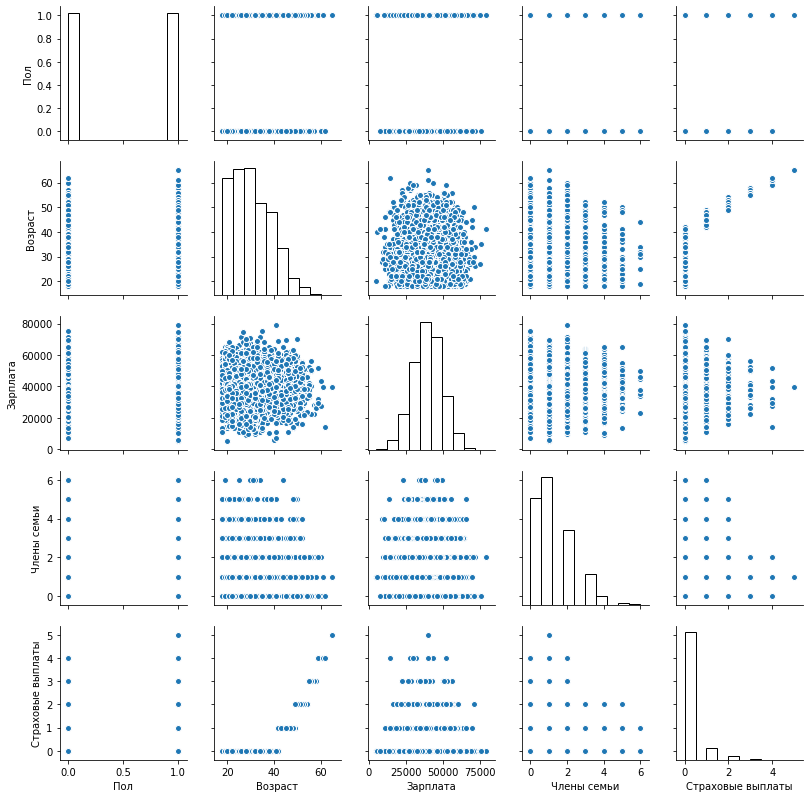

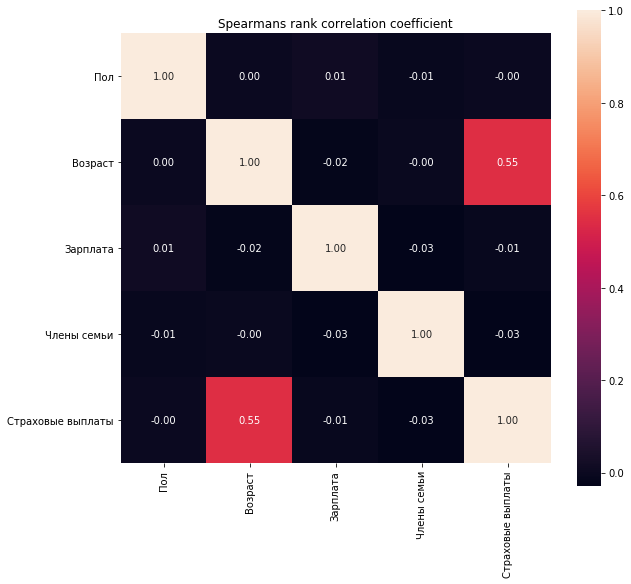

In [8]:
eda_plot(df)

Итак, из приведенных выше матриц можно заметить, что представленные переменные весьма весьма неоднородны в своем распределение: 
 * переменная **Пол** имеет распределение Бернулли;
 * переменные **Возраст**, **Члены семьи** и **Страховые выплаты** имеют распределения, скошенные вправо;
 * переменная **Зарплата** обладает нормальным распределением.
 
Визуальная составляющая диаграмм рассеяния указывает на малую взаимосвязь всех признаком на переменную **Страховые выплаты**, кроме признака, указывающего на **возраст** клиентов. Данное предположение подтверждается анализом коэффициентов корреляции *Спирмена*, который между перемеными **Возраст** и **Страховые выплаты** составил **0.55**, что согласно *шкале Чеддока* свидетельствует о *заметном* характере взаимосвязи. Помимо этого отсутствует мультиколлинеарность остальных параметров.

## Умножение матриц

*Предположим*, чтобы защитить данные клиентов - преобразуем их путем домножения матрицы признаков на произвольную *обратимую* матрицу, и данное преобразование не скажется на финальном качестве модели линейной регрессии. 

### Обоснование

Обозначения:

- $X$ — матрица признаков (нулевой столбец состоит из единиц), $X\in{\mathbb{R}^{nxm}}$

- $\hat{X}$ — матрица новых признаков, $\hat{X}\in{\mathbb{R}^{kxm}}$

- $y$ — вектор целевого признака, $y\in{\mathbb{R}^{nx1}}$

- $\hat{y}$ — новый вектор целевого признака, $\hat{y}\in{\mathbb{R}^{kx1}}$

- $P$ — матрица, на которую умножаются признаки, $P\in{\mathbb{R}^{mxm}}$

- $E$ — удиничная матрица, $E\in{\mathbb{R}^{mxm}}$

- $w$ — вектор весов линейной регрессии (нулевой элемент равен сдвигу), $w\in{\mathbb{R}^{mx1}}$

Вектор предсказания:

$$
y = Xw
$$

Задача обучения - нахождения минимума и возвращения аргумента, при котором оный был достигнут:

$$
w = \arg\min_w MSE(Xw, y)
$$

Тогда формула обучения будет иметь следующий вид:

$$
w = (X^T X)^{-1} X^T y
$$

Таким образом, если мы воспользуемся полученным вектором весов $w$, для предсказания целевого признака $\hat{y}$ на основе матрицы признаков $\hat{X}$ , то форма вектора предсказаний будет иметь следующий вид:

$$
\hat{y} = \hat{X}w = \hat{X}(X^T X)^{-1} X^T y
$$

Домножим признаки на *обратимую* матрицу $P$, т.е. для данной матрицы справедливо следующее: $\det{P}\neq{0}; \exists{C}$ такая, что $PC=CP=E$. Докажем, что

$$
\hat{y} = \hat{X}P [(XP)^T XP]^{-1} (XP)^T y = \hat{X} (X^T X)^{-1} X^T y
$$

В рамках доказательста будем пользоваться следующими свойствами матричных преобразований:

$$
AA^{-1} = A^{-1} A = E
$$
$$
AE = EA = A
$$
$$
(AB)^T = B^T A^T
$$
$$
(AB)^{-1} = B^{-1} A^{-1}
$$

Тогда:

$$
\hat{y} = \hat{X}P [(XP)^T XP]^{-1} (XP)^T y = \hat{X}P (P^T X^T XP)^{-1} P^T X^T y = \hat{X}P P^{-1} [P^T (X^T X)]^{-1} P^T X^T y = \hat{X}P P^{-1} (X^T X)^{-1} P^{-T} P^T X^T y = \hat{X}E (X^T X)^{-1} E X^T y = \hat{X} (X^T X)^{-1} X^T y
$$

### Вывод

Итак, подытожим, домножение матрицы признаков на обратимую произвольную матрицу не влияет на предсказания, осуществляемые моделью линейной регрессии, что было показанно при помощи свойств преобразования матриц. Наше *предположение*, выдвинутое в начале оного пункта не может быть отвергнуто.

## Алгоритм преобразования

Теперь проверим работу алгоритма. Определим функцию, которая будет создавать матрицу $P$. Данная функция будет иметь возможность зафиксировать случайную генерацию. Помимо этого функция будет проверять условия обратимости полученной матрицы.

In [9]:
def arbitrary_matrix(data, fix):
    
    width=data.shape[1]
    
    if fix==True:
        np.random.seed(42)
        P = np.random.rand(width, width)
        if np.linalg.det(P)==0:
            P = np.random.rand(width,width)
            
    elif fix==False:
        P = np.random.rand(width, width)
        if np.linalg.det(P)==0:
            P = np.random.rand(width,width)
            
    return P

Создадим матрицу преобразования матрицы признаков $X$ путем умножения на $P$.

In [10]:
def features_transform(data, invertible_matrix):
    
    X = data.values
    transformed_features = X @ invertible_matrix
    
    return transformed_features

Разделим наши исходные данные на тренировочную и валидационную выборки.

In [11]:
features = df.drop(['Страховые выплаты'], axis=1)
target = df['Страховые выплаты']

Преобразуем признаки при помощи ранее созданных функций.

In [12]:
P = arbitrary_matrix(features, True)
new_features = pd.DataFrame(features_transform(features, P), columns=features.columns)

Посмотрим как изменились наши данные.

In [13]:
new_features.sample(n=10, replace=True, random_state=42)

,Пол,Возраст,Зарплата,Члены семьи
860,26638.080744,31375.059628,914.870510,43006.351186
3772,21585.552077,25425.904076,741.632098,34848.946164
3092,27958.151295,32932.253374,960.118156,45134.321478
466,15456.301745,18203.250086,531.483738,24955.817227
4426,21826.414818,25708.309830,749.764877,35230.347505
3444,20923.753839,24645.832629,718.648227,33774.433146
3171,20624.746366,24292.149927,708.212396,33295.126199
2919,34026.542075,40080.339783,1166.360217,54915.953508
130,29638.246470,34911.253970,1016.035325,47834.745411
1685,15754.736463,18557.600072,541.962504,25440.820598


Выглядит весьма необычно, но это для нас - людей. Что скажет по этому поводу машина, давайте узнаем? Согласно проведенным преобразованиям для алгоритма оба набора признаков должны быть эквивалентны.

## Проверка алгоритма

Создадим функцию для обучения регрессии.

In [14]:
def model_fit(features_initial, target_initial, model):
    
    features_train, features_valid, target_train, target_valid = train_test_split(features_initial, 
                                                                                  target_initial, 
                                                                                  test_size=0.25, 
                                                                                  random_state=42)
    cv_r2 = cross_val_score(model,
                    features_initial,
                    target_initial,
                    scoring='r2',
                    cv=8,
                    n_jobs=-1)
    
    model.fit(features_train, target_train)
    predictions = model.predict(features_valid)
    r2 = r2_score(target_valid, predictions)
    
    result = [round(cv_r2.mean(), 2), round(r2, 2)]
    
    print('Итоги обучения модели:')
    print('')
    print('- Среднее R2 для скользящего контроля: {:.2f}'.format(cv_r2.mean()))
    print('')
    print('- R2: {:.2f}'.format(r2))
    
    f, ax = plt.subplots(2, 2, figsize=(12, 12))
        
    lims = [0, target_valid.max()]
    error = predictions - target_valid

    ax[0,0].set_title('Errors estimation')
    ax[0,0].scatter(target_valid, predictions, edgecolors=(0, 0, 0))
    ax[0,0].plot(lims, lims, 'k--', color='red', lw=4)
    ax[0,0].set_xlabel('True values')
    ax[0,0].set_ylabel('Predicted')

    ax[0,1].set_title('Errors distribution')
    ax[0,1].hist(error, bins=50)
    ax[0,1].set_xlabel('Prediction Error')
    ax[0,1].set_ylabel('Frequency')
    
    importances= model.coef_
    feature_names = features_initial.columns
                     
    model_importances = pd.Series(importances, index=feature_names)
    
    ax[1,0].bar(x=model_importances.index, height=model_importances.values)
    ax[1,0].set_title('Feature importances')
    ax[1,0].set_ylabel('Coefficients')
    plt.xticks(rotation = 90)
    f.tight_layout()
    
    ax[1,1].plot(range(len(cv_r2)), cv_r2)
    ax[1,1].set_title('Cross-validation score')
    ax[1,1].set_ylabel('R2 score')
    ax[1,1].set_xlabel('Iteration')
    ax[1,1].set_ylim([0, max(cv_r2)*1.1])
    plt.xticks(rotation=0)
    
    plt.show()
    
    return result

Зададим модель линейной регрессии - **LinearRegression()**.

In [15]:
model = LinearRegression()

В качестве метрики будем использовать *коэффициент детерминации* - $R^2$.

$$
R^2 = 1 - \frac{\sum_{i=1}^{\infty} (\hat{y_i} - y_i)^2}{\sum_{i=1}^{\infty} (y_i - \bar{y})^2}
$$

где 
 - $\hat{y_i}$ - расчетные значения целевого признака
 - $y_i$ - фактические значение целевой переменной 
 - $\bar{y_i}$ - выборочное среднее 

Данный показатель измеряет долю дисперсии, объясненную моделью, в общей дисперсии целевой переменной. $\{R^2\in{\mathbb{R}}:0 \leqslant R^2 \leqslant 1\}$, где $1$ -  модель хорошо объясняет данные, а $0$ - прогнозы сопоставимы по качеству с константным предсказанием.

Сначала обучим и оценим качество модели на оригинальных данных, а затем на преобразованных.

Итоги обучения модели:

- Среднее R2 для скользящего контроля: 0.42

- R2: 0.43


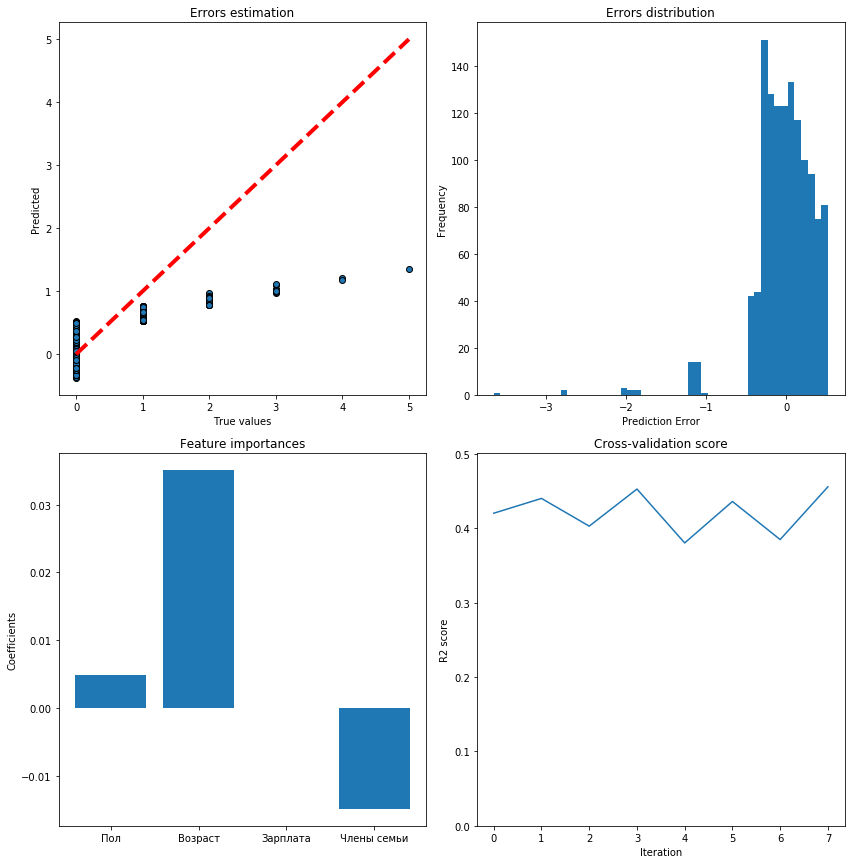

In [16]:
origin_results =  model_fit(features, target, model)

Итоги обучения модели:

- Среднее R2 для скользящего контроля: 0.42

- R2: 0.43


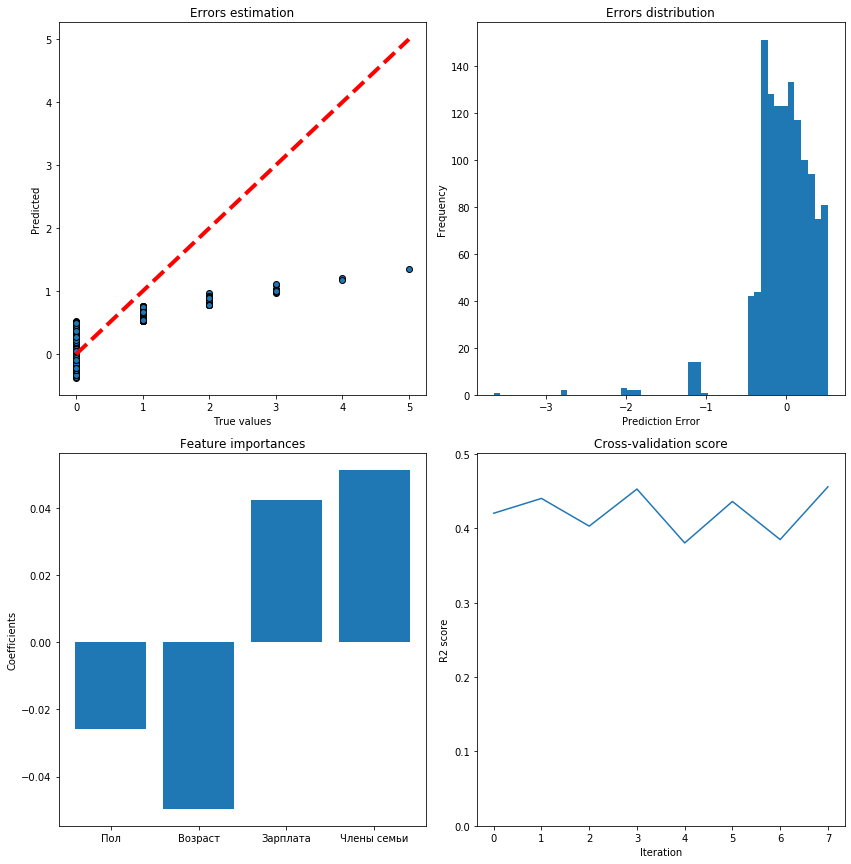

In [17]:
transformed_results = model_fit(new_features, target, model)

## Вывод

Итак, в исходной таблице с характеристиками клиентов не было выявлено пропусков, а последующее построение матрицы диаграмм рассеяния и расчет рангового коэффициента *Спирмена* позволили оценить мультиколлинеарность представленных переменны, наличие которой не было выявлено в виду отсутсвия сильной зависимости между объясняющими переменными.

Был разработан алгоритм преобразования данных путем умножения матрицы признаков на *обратимую* матрицу. Как удалось выяснить в ходе аналитического разбора данного алгоритма, оный никоим образом не влияет на финальное качество модели обучения в случае *линейной регрессии*. Данные выводы были подтверждены на основе пакета **LinearRegression()** модуля **scikit-learn**. В качестве метрики оценивания качества модели был использован *коэффициент детерминации* - $R^2$. Значение выбранной метрики оказались одинаковы как для исходных данных, так и для преобразованных - **0.42** - среднее при скользящем контроле и **0.43** на валидационной выборки, составившей *25%* от оригинального датафрейма. Однако, стоит заметить: после преобразования веса признаков модели поменяли свои значения, что не противоречит аналитическому решению.

## Чек-лист проверки

Поставьте 'x' в выполненных пунктах. Далее нажмите Shift+Enter.

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Выполнен шаг 1: данные загружены
- [x]  Выполнен шаг 2: получен ответ на вопрос об умножении матриц
    - [x]  Указан правильный вариант ответа
    - [x]  Вариант обоснован
- [x]  Выполнен шаг 3: предложен алгоритм преобразования
    - [x]  Алгоритм описан
    - [x]  Алгоритм обоснован
- [x]  Выполнен шаг 4: алгоритм проверен
    - [x]  Алгоритм реализован
    - [x]  Проведено сравнение качества моделей до и после преобразования